#Numerical Analysis' project

Movie recommendation system

In [1]:
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr
from numpy.linalg import matrix_rank
from tqdm.notebook import tqdm
from enum import IntEnum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import jax
import time

In [2]:
# Upload the dataset
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [3]:
# Create 2 sets containing all the possible user and movie ids
userIds_available = set()
movieIds_available = set()
for id in np.array(ratings['userId'] , dtype = int):
    userIds_available.add(id)

for id in np.array(movies['movieId'] , dtype = int):
    movieIds_available.add(id)
    
# Convert the sets in 2 lists
userIds_available = list(userIds_available)
movieIds_available = list(movieIds_available)

# Order the list
userIds_available.sort()
movieIds_available.sort()

print(len(userIds_available) , len(movieIds_available))

668 10329


In [4]:
def binary_search(array , x):
    low = 0
    high = len(array) - 1
    while(high >= low):
        mid = int((high + low) / 2)
        
        if array[mid] == x:
            return mid
        
        elif array[mid] > x:
            high = mid - 1
            
        else:
            low = mid + 1

    print("Element %d not found" % x)
    return -1

In [5]:
rows = np.array(ratings['userId'])
cols = np.array(ratings['movieId'])
vals = np.array(ratings['rating'])

n = rows.max() # Max user id
p = cols.max() # Max movie id
N = len(vals)  # Number of ratings

# Update the arrays rows/cols with the true position instead of the ids 
for i_user in tqdm(range(len(rows))):
    rows[i_user] = binary_search(userIds_available ,  rows[i_user])

for i_movie in tqdm(range(len(cols))):
    cols[i_movie] = binary_search(movieIds_available , cols[i_movie])

n , p , N

  0%|          | 0/105339 [00:00<?, ?it/s]

  0%|          | 0/105339 [00:00<?, ?it/s]

(668, 149532, 105339)

In [6]:
# Shuffle the data
indexes = np.arange(N)
np.random.seed(0) # for reproducibility
np.random.shuffle(indexes)
# Reordering the arrays
rows = rows[indexes]
cols = cols[indexes]
vals = vals[indexes]

In [7]:
# Split data in training and testing
num_training = int(N * 0.8)

rows_train  = rows[:num_training]
cols_train  = cols[:num_training]
vals_train  = vals[:num_training]
rows_test   = rows[num_training:]
cols_test   = cols[num_training:]
vals_test   = vals[num_training:]

print(len(rows_train) , len(cols_train) , len(vals_train))

84271 84271 84271


Building the 'Ratings matrix' 

Users on the rows and Movies on the columns

Initializing all the elements to 0 and then update position (i,j) with the rating of movie j by user i if it's present

In [8]:
ratings_matrix = np.zeros((len(userIds_available) , len(movieIds_available)))

def init_ratings_matrix():
  # Initialize the matrix with all zeros
  ratings_matrix = np.zeros((len(userIds_available) , len(movieIds_available)))
  # Update the matrix with the known values (contained in vals_train array)
  ratings_matrix[rows_train, cols_train] = vals_train
  return ratings_matrix

ratings_matrix = init_ratings_matrix()

In [9]:
# Count the number of missing values
def count_missing_values(matrix):
    missing_values = 0

    for i_user in tqdm(range(matrix.shape[0])):
        for j_movie in range(matrix.shape[1]):
            # If the movie in position j_movie hasn't a rating
            if matrix[i_user , j_movie] == 0:
                missing_values += 1

    print("There are %d missing valuess" % (missing_values))
    print("There are %d values inserted" % (matrix.shape[0] * matrix.shape[1] - missing_values))
    print("There are %d values" % (matrix.shape[0] * matrix.shape[1]))
    
count_missing_values(ratings_matrix)

  0%|          | 0/668 [00:00<?, ?it/s]

There are 6815501 missing valuess
There are 84271 values inserted
There are 6899772 values


Building movie-genre correlation matrix M

$$
M_{i,j} = 
\begin{cases}
1 & \text{if movie i is of genre j}\\
0 & \text{otherwise}
\end{cases}
$$

In [10]:
# Put in a set all the genres available
genre_available = set()

for i in range(movies.shape[0]):
    genres = movies['genres'][i].split('|')
    for g in genres: genre_available.add(g)

# print("All genres available are: " , id_available , genre_available)

In [11]:
num_movies = len(movieIds_available)
num_genres = len(genre_available)
print("Max movie id: " , max(movies['movieId']))
print("Number of movies is: " , num_movies)
print("Number of genres is: " , num_genres)

Max movie id:  149532
Number of movies is:  10329
Number of genres is:  20


In [12]:
# Initialize the matrix with all zeros of int8 type
correlation_matrix = np.zeros((num_movies , num_genres) , dtype = np.int8)
# Update the table with the correspondance
for i in tqdm(range(movies.shape[0])):
    id = movies['movieId'][i]
    # Take the right position in the matrix
    id = movieIds_available.index(id)

    genres = movies['genres'][i].split('|')
    for pos , g in enumerate(genre_available):
        if g in genres:
            correlation_matrix[id , pos] = 1

  0%|          | 0/10329 [00:00<?, ?it/s]

In [13]:
def cosine_similarity(vector1 , vector2):
    """
    vector1 and vector2 are rows of correlation_matrix or of ratings_matrix
    """
    return np.dot(vector1, vector2)/(np.linalg.norm(vector1) * np.linalg.norm(vector2))

def cosine_similarity_users(vector1 , vector2):
    '''
    Apply this similarity between users -> want to find similar behaviour in rating common movies and then
        use it for movies that one of the two hasn't watched yet, not use them here
    vector1 and vector2 are vector containing ratings of two users 
    '''
    common_vector1 = []
    common_vector2 = []
    
    # Take just the movies rated in both the array to find a similarity between the two users
    for i in range(len(vector1)):
        if vector1[i] != 0 and vector2[i] != 0:
            common_vector1.append(vector1[i])
            common_vector2.append(vector2[i])
    # If the two vectors(users) has at least 5 common ratings
    if len(common_vector1) > 5:
        return np.dot(common_vector1, common_vector2)/(np.linalg.norm(common_vector1) * np.linalg.norm(common_vector2))
    else:
        return 0

In [14]:
# Creating clusters for movies
# Key is the number of the cluster, value is a list of movie ids
movies_cluster = {}
# Over the threshold movies are considered similar
threshold = 0.7
# Key is the movie id, value is the cluster's number of the movie
movie_index_cluster = {}
# Create a copy of the ids available
movieIds_copy = movieIds_available.copy()

num_cluster = 0
index1 = 1
# To show the progress bar
pbar = tqdm(total = len(movieIds_copy))

# While there is a movie not yet assigned to a cluster
while len(movieIds_copy) > 0:
    # Pick the first of the actual list
    id_x = movieIds_copy[0]
    # Create an empty list that will contains all the similar movies of id_x
    list_movies = []
    # Set the cluster for the current movie
    movie_index_cluster[id_x] = num_cluster
    # Add the current movie in the current cluster
    list_movies.append(id_x)
    # Pick all the others not yet in a cluster and check if they are similar to id_x
    while (index1 < len(movieIds_copy)):
        id_y = movieIds_copy[index1]
        sim = cosine_similarity(correlation_matrix[movieIds_available.index(id_x)], correlation_matrix[movieIds_available.index(id_y)])
        # If they are similar enough
        if sim >= threshold:
            # Set the cluster for id_y
            movie_index_cluster[id_y] = num_cluster
            # Add id_y in the list
            list_movies.append(id_y)
            # Remove id_y from the list of movies not yet assigned
            movieIds_copy.remove(id_y)
            # Update the bar when an element is deleted
            pbar.update(1)
        else:
            # Increment the index
            index1 += 1
    # Remove id_x from the list of movies not yet assigned
    movieIds_copy.remove(id_x)
    # Update the bar when an element is deleted
    pbar.update(1)
    # Set the list of movies to the cluster
    movies_cluster[num_cluster] = list_movies
    num_cluster += 1
    index1 = 1
    
# Close the bar
pbar.close()
print("Number of cluster is: " , num_cluster)

  0%|          | 0/10329 [00:00<?, ?it/s]

Number of cluster is:  200


In [15]:
# Creating clusters for users
# Key is the number of the cluster, value is a list of user ids
users_cluster = {}
# Over the threshold users are considered similar
threshold = 0.95
# Key is the user id, value is the cluster's number of the user
user_index_cluster = {}
# Create a copy of the ids available
userIds_copy = userIds_available.copy()

num_cluster = 0
index2 = 1
# To show the progress bar
pbar = tqdm(total = len(userIds_copy))

# While there is a user not yet assigned to a cluster
while len(userIds_copy) > 0:
    # Pick the first of the actual list
    id_x = userIds_copy[0]
    # Create an empty list that will contains all the similar users of id_x
    list_users = []
    # Set the cluster for the current user
    user_index_cluster[id_x] = num_cluster
    # Add the current movie in the current cluster
    list_users.append(id_x)
    # Pick all the others not yet in a cluster and check if they are similar to id_x
    while ( index2 < len(userIds_copy)):
        id_y = userIds_copy[index2]
        sim = cosine_similarity_users(ratings_matrix[userIds_available.index(id_x)], ratings_matrix[userIds_available.index(id_y)])
        # If they are similar enough
        if sim >= threshold:
            # Set the cluster for id_y
            user_index_cluster[id_y] = num_cluster
            # Add id_y in the list
            list_users.append(id_y)
            # Remove id_y from the list of users not yet assigned
            userIds_copy.remove(id_y)
            # Update the bar when an element is deleted
            pbar.update(1)
        else :
            # Increment the index
            index2 += 1
    # Remove id_x from the list of users not yet assigned
    userIds_copy.remove(id_x)
    # Update the bar when an element is deleted
    pbar.update(1)
    # Set the list of users to the cluster
    users_cluster[num_cluster] = list_users
    num_cluster += 1
    index2 = 1
    
# Close the bar
pbar.close()
print("Number of cluster is: " , num_cluster)

  0%|          | 0/668 [00:00<?, ?it/s]

Number of cluster is:  161


In [16]:
class Movie:
    def __init__(self , genre , rating):
        # The true vector of genres
        self.genre = genre
        # A list of possible ratings
        self.possible_rating = list([0.5 , 1 , 1.5 , 2 , 2.5 , 3 , 3.5 , 4 , 4.5 , 5])
        # The one-hot array for the rating
        self.rating_one_hot = np.zeros(10)
        # Convert the rating received in the one-hot configuration
        self.convert_rating(rating)
        
    def convert_rating(self , rating):
        # Calculate the mean (both in case of array or scalar value)
        mean_rating = np.mean(rating)
        # Approximate the rating
        if mean_rating - int(mean_rating) > 0.75:
            mean_rating = int(mean_rating) + 1.0
        elif mean_rating - int(mean_rating) > 0.25:
            mean_rating = int(mean_rating) + 0.5
        else:
            mean_rating = int(mean_rating)
        # Take the position corresponding to the rating calulated
        index = self.possible_rating.index(mean_rating)
        # Update the one-hot array
        self.rating_one_hot[index] = 1

movie = Movie([1 , 0 , 0 , 1] , [2 , 2 , 4.5])
movie.genre , movie.rating_one_hot

([1, 0, 0, 1], array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))

In [17]:
# Key: user_id , value: list of Movie objects (necessary for the training of the NN)
ratings_for_the_user = {}
# Initiliaze all the values of the dictionary as a list
for userId in userIds_available:
    ratings_for_the_user[userId] = list()
    
# Converting the list of position in list of ids
userIds_to_consider = [userIds_available[rows_train[i]] for i in range(len(rows_train))]
movieIds_to_consider = [movieIds_available[cols_train[i]] for i in range(len(cols_train))]

# For each users cluster
for cluster , users_in_cluster in tqdm(users_cluster.items()):
    # Consider just the users in the cluster
    rows_to_consider = [userIds_to_consider[i] for i in range(len(userIds_to_consider)) if userIds_to_consider[i] in users_in_cluster]
    cols_to_consider = [movieIds_to_consider[i] for i in range(len(movieIds_to_consider)) if userIds_to_consider[i] in users_in_cluster]
    vals_to_consider = [vals_train[i] for i in range(len(userIds_to_consider)) if userIds_to_consider[i] in users_in_cluster]
    
    # Add all the Movie object related to movies rated by the user
    for i in range(len(cols_to_consider)):
        # Take the genres of the movie in position i
        movie_genre = correlation_matrix[movieIds_available.index(cols_to_consider[i])]
        # Create the object Movie for the user in position i with rating in position i 
        movie_obj = Movie(movie_genre , vals_to_consider[i])
        # Append the object in the dictionary
        # Read the old list
        current_value = ratings_for_the_user[rows_to_consider[i]]
        # Add the new object
        current_value.append(movie_obj)
        # Append the new list
        ratings_for_the_user[rows_to_consider[i]] = current_value
        
    # Calculate the average of the ratings given to a movie
    # Dictionary containing all the movie already calculated: key is it movieId , value is the average rating
    movie_avgs = {}
    
    for movieId in cols_to_consider:
        # If the movie has not already been considered
        if movieId not in movie_avgs.keys():
            # Take the genre of that movie
            movie_genre = correlation_matrix[movieIds_available.index(movieId)] 
            # Take the cluster of the movie
            cluster = movie_index_cluster[movieId]
            # Take all the movies in the cluster
            similar_movies = movies_cluster[cluster]
            # Take the position of all the ratings for movie with similar genres of movieId
            indexes = [i for i in range(len(cols_to_consider)) if cols_to_consider[i] in similar_movies]
            # Take the relevant values for movieId
            values = [vals_to_consider[i] for i in indexes]
            # Calculate the mean of all the ratings for the movie
            average = np.mean(values)
            # Add the movie with his average
            movie_avgs[movieId] = average
            # Add the mean rating to all the similar movies if present
            for movieId_sim in similar_movies:
              # If it's a movie to consider for this user' cluster
              if movieId_sim != movieId and movieId_sim in cols_to_consider:
                movie_avgs[movieId_sim] = average

    # For each user in the cluster, add Movie objects of movie not watched
    for userId in users_in_cluster:
        # Take just the movies rated by the user
        cols_of_user = [cols_to_consider[i] for i in range(len(rows_to_consider)) if rows_to_consider[i] == userId]
        
        # Read the old list of the user userId
        current_value = ratings_for_the_user[userId]
        
        # For each movie not present, add it
        for movieId , rating in movie_avgs.items():
            # If the user hasn't rated the movie movieId
            if movieId not in cols_of_user:
                # Take the genres of the movie movieId
                movie_genre = correlation_matrix[movieIds_available.index(movieId)]
                # Create the object Movie for the user userId of the movie movieId 
                movie_obj = Movie(movie_genre , movie_avgs[movieId])
                # Add the new object
                current_value.append(movie_obj)
            
        # Save the new list
        ratings_for_the_user[userId] = current_value
                

  0%|          | 0/161 [00:00<?, ?it/s]

In [18]:
# Function that initialize the parameters (weights and biases)
# W -> Glorot normal initialization
# b -> 0 vector
def init_params(layers_size):
    np.random.seed(0)
    params = list()
    for i in range(len(layers_size) - 1):
        w = np.random.randn(layers_size[i + 1] , layers_size[i]) * np.sqrt(2) / np.sqrt(layers_size[i + 1] + layers_size[i])
        b = np.zeros((layers_size[i + 1] , 1))
        params.append(w)
        params.append(b)
    return params

In [54]:
def ANN(x , params):
    # Take the parameters
    W = params[0::2]
    b = params[1::2]
    # Calculate the number of layers
    num_layers = int(len(params) / 2 + 1)

    layer = x
    
    # For each layer except the last one
    for i in range(num_layers - 1):
        layer = W[i] @ layer + b[i]
        
        # If it's not the last layer apply the activation function
        if i < len(W) - 2:
            # If tanh
            #layer = jnp.tanh(layer)
            # If relu
            #layer = jnp.maximum(0.0 , layer)
            # If leaky-reLu
            #layer = jnp.maximum(0.1 * layer , layer)
            # If swish
            layer = layer / (1 + jnp.exp(-layer))
    
    # Apply softmax in the output to obtain a vector of probability as output
    layer = jnp.exp(layer) / jnp.sum(jnp.exp(layer) , axis = 0)
    return layer

In [55]:
# Testing the NN
# Init the params
params = init_params([20 , 32 , 16 , 10])
# Create a random Movie object
movie_obj = Movie(correlation_matrix[0] , 3)
# Call ANN function
out = ANN(movie_obj.genre[: , None] , params)
# Check the shape and the sum
out.shape , np.sum(out , axis = 0)

((10, 1), DeviceArray([1.0000001], dtype=float32))

In [56]:
# Mean Square Error loss function
def MSE_function(x , y , params):
    err = y - ANN(x , params)
    return jnp.mean(err**2)
    
MSE_function(movie_obj.genre[: , None] , movie_obj.rating_one_hot, params)

DeviceArray(0.0907837, dtype=float32)

In [57]:
# Cross entropy loss function
def loss_crossentropy(x , y , params):
  y_pred = ANN(x , params)
  loss = - jnp.sum(y * jnp.log(y_pred) + (1 - y) * jnp.log(1 - y_pred))
  return loss

loss_crossentropy(movie_obj.genre[: , None] , movie_obj.rating_one_hot, params)

DeviceArray(32.97543, dtype=float32)

In [58]:
# Use jax to define the grad and then add jit
# If RMSE loss
#loss_jit = jax.jit(MSE_function)
#grad_jit = jax.jit(jax.grad(MSE_function , argnums=2))
# If crossentropy loss
loss_jit = jax.jit(loss_crossentropy)
grad_jit = jax.jit(jax.grad(loss_crossentropy , argnums=2))

In [61]:
def train_NN(movies , params):
    epochs = 2000
    alpha = 0.90
    learning_rate_min = 1e-4
    learning_rate_max = 1e-2
    learning_rate_decay = 1000

    # Retrive input and output vectors from the list of Movie objects
    x = np.array([movies[i].genre[: , None] for i in range(len(movies))])
    y = np.array([movies[i].rating_one_hot[: , None] for i in range(len(movies))])
    # Calculate the size of the minibatch according to the number of input vectors
    if len(x) == 1:
      batch_size = 1
    else:
      batch_size = int(0.3 * len(x)) + 1
    
    # "Velocity" vector initialize to 0 (in case of SGD with momentum)
    v = [0.0 for _ in range(len(params))]
    
    for epoch in range(epochs):
        # Calculate the learning rate for this epoch
        learning_rate = max(learning_rate_min , learning_rate_max * (1 - epoch) / learning_rate_decay)
        # Creating the random minibatch
        minibatch = np.random.choice(len(x) , batch_size)
        # Calculate the gradient on the minibatch
        grad = grad_jit(x[minibatch , : , : ] , y[minibatch , : , :] , params)
        
        # Update the params
        for i in range(len(params)):
          # If with momentum
          v[i] = alpha *  v[i] - learning_rate * grad[i]
          params[i] += v[i]

          # If SGD
          #params[i] -= learning_rate * grad[i]

    # Return the updated params for the user
    return params

Training of the neural networks

In [62]:
# Reinitialize the ratings matrix
ratings_matrix = init_ratings_matrix()

# Create a dictionary with key the user ids and with value the params(W and b) associated to him
# Every user has his own neural network
users_params = {}

# Defining the layers size of the neural network
layers_size = [20 , 32 , 16 , 10]

# Initialize all the params for each user
for userId in userIds_available:
    users_params[userId] = init_params(layers_size)

# For each user train his network
for userId in tqdm(userIds_available):
  # Take the params currently saved
  current_params = users_params[userId]
  # Take the list of movie_obj for the user from the dictionary
  movies_obj = ratings_for_the_user[userId]
  # Train the network
  updated_params = train_NN(movies_obj , current_params)
  # Save the updated params
  users_params[userId] = updated_params

  0%|          | 0/668 [00:00<?, ?it/s]

Prediction phase

In [63]:
# Reinitialize the ratings matrix
ratings_matrix = init_ratings_matrix()

# If the difference between the 2 biggest probability is greater than the threshold,
#   the NN is considered sure enough
difference_threshold = 0.3
# Predict a rate for each movie and for each user
for user_i in tqdm(range(ratings_matrix.shape[0])):
  # Take the user id corresponding to the row user_i
  userId = userIds_available[user_i]
  # Take the params of the user
  params = users_params[userId]
  # For each movie calculate the prediction
  for movie_j in range(ratings_matrix.shape[1]):
    # If the user didn't rate the movie
    if ratings_matrix[user_i , movie_j] == 0:
      # Take the genre of the movie movie_j
      movie_genre = correlation_matrix[movie_j]
      # Calculate the prediction
      prediction = ANN(movie_genre[: , None] , params)
      # Take the index of the element with the highest probability (and convert it in the rate number)
      best_rate = float(jnp.argmax(prediction , axis = 0)) / 2 + 0.5
      # Sort the precition array
      prediction = np.sort(prediction , axis = 0)
      # If the NN is almost sure -> if the threshold is satisfied
      if prediction[-1] - prediction[-2] > difference_threshold:
        # Save the prediction
        ratings_matrix[user_i , movie_j] = best_rate

  0%|          | 0/668 [00:00<?, ?it/s]

In [64]:
# Calculate how many predictions have been performed
count_missing_values(ratings_matrix)

  0%|          | 0/668 [00:00<?, ?it/s]

There are 2740841 missing valuess
There are 4158931 values inserted
There are 6899772 values


In [65]:
# Analyzing the errors/precision/recall/f1 score after the prediction of the ratings predicted only
# Initialize the list for the evaluation of the initial errors
rows_test_limited = list()
cols_test_limited = list()
vals_test_limited = list()

# Fill the list
def fill_test_lists():
  for i in range(len(rows_test)):
    # Add just the position filled with the algortithm
    if ratings_matrix[rows_test[i]][cols_test[i]] != 0:
        rows_test_limited.append(rows_test[i])
        cols_test_limited.append(cols_test[i])
        vals_test_limited.append(vals_test[i])

# Calculate RMSE and rho
def analyze_starting_errors():
  vals_pred_limited = ratings_matrix[rows_test_limited, cols_test_limited]
  err = vals_test_limited - vals_pred_limited
  RMSE = np.sqrt(np.mean(err**2))
  rho = pearsonr(vals_test_limited, vals_pred_limited)[0]
  return RMSE , rho

# Evaluate the precision and the recall before apply SVT
def precision_and_recall_initial_state():
    total_recommended = 0 # true positive + false negative
    predicted_recommended_items = 0 # true positive + false positive
    predicted_true_recommended_items = 0 # true positive
    # A movie is recommended if it's rating is greater than this value
    recommendation_value = 3
    for i in range(len(rows_test_limited)):
        true_rating = vals_test_limited[i]
        predicted_value = ratings_matrix[rows_test_limited[i]][cols_test_limited[i]]
        # Calculate true positive
        if true_rating >= recommendation_value: 
            total_recommended += 1
            if predicted_value >= recommendation_value:
                predicted_true_recommended_items += 1
        # Calculate true positive + false positive
        if predicted_value >= recommendation_value:
            predicted_recommended_items += 1
                
    print("True positive: " , predicted_true_recommended_items)
    print("True positive + false positive: " , predicted_recommended_items)
    print("True positive + false negative: " , total_recommended)
    precision = predicted_true_recommended_items / predicted_recommended_items
    recall = predicted_true_recommended_items / total_recommended
    print("Precision: " , precision)
    print("Recall: " , recall)
    return precision , recall

# Calculate the F1-score
def F1_measure(precision_value , recall_value):
    return 2 * precision_value * recall_value / ( precision_value + recall_value)

fill_test_lists()
print(analyze_starting_errors()) 
print("At this stage %d values have already been predicted" % len(rows_test_limited))
precision , recall = precision_and_recall_initial_state()
F1_measure(precision , recall)

(1.2830854844778432, 0.09299499521017576)
At this stage 11973 values have already been predicted
True positive:  8711
True positive + false positive:  10241
True positive + false negative:  10076
Precision:  0.8506005272922567
Recall:  0.8645295752282652


0.8575084904267362

In [66]:
# Reconstruct rows_train, cols_train, vals_train with all the value of the input + already predicted values
counter = 0
rows_train_updated = list()
cols_train_updated = list()
vals_train_updated = list()
for i_user in tqdm(range(ratings_matrix.shape[0])):
    for j_movie in range(ratings_matrix.shape[1]):
        # If it is a default or predicted value, save the position
        if ratings_matrix[i_user][j_movie] != 0:
            rows_train_updated.append(i_user)
            cols_train_updated.append(j_movie)
            vals_train_updated.append(ratings_matrix[i_user][j_movie])
            counter += 1
print("Saved %d values" % counter)

  0%|          | 0/668 [00:01<?, ?it/s]

Saved 4158931 values


In [67]:
# Calculate RMSE and rho for the whole matrix
def errors():
    vals_pred = X_hat[rows_test, cols_test]
    err = vals_test - vals_pred
    RMSE = np.sqrt(np.mean(err**2))
    rho = pearsonr(vals_test, vals_pred)[0]
    return RMSE , rho

In [68]:
X_hat = ratings_matrix

In [78]:
# Perform some evaluations
def precision_and_recall():
    total_recommended = 0 # true positive + false negative
    predicted_recommended_items = 0 # true positive + false positive
    predicted_true_recommended_items = 0 # true positive
    # A movie is recommended if it's rating is greater than this value
    recommendation_value = 3
    for i in range(len(rows_test)):
        true_rating = vals_test[i]
        predicted_value = X_hat[rows_test[i]][cols_test[i]]
        # Calculate true positive
        if true_rating >= recommendation_value: 
            total_recommended += 1
            if predicted_value >= recommendation_value:
                predicted_true_recommended_items += 1
        # Calculate true positive + false positive
        if predicted_value >= recommendation_value:
            predicted_recommended_items += 1
                
    #print("True positive: " , predicted_true_recommended_items)
    #print("True positive + false positive: " , predicted_recommended_items)
    #print("True positive + false negative: " , total_recommended)
    precision = predicted_true_recommended_items / predicted_recommended_items
    recall = predicted_true_recommended_items / total_recommended
    #print("Precision: " , precision)
    #print("Recall: " , recall)
    return precision , recall
  
precision , recall = precision_and_recall()
F1_measure(precision , recall)

SVT

In [70]:
n_max_iter = 100

increment_tol = 1e-1

# Threshold parameters
a = 0.01
b = 200

RMSE_list = list()
rho_list = list()
precision_list = list()
recall_list = list()
f1_score_list = list()

# Calculating initial errors / parameters
RMSE , rho = errors()
precision , recall = precision_and_recall()
f1_score = F1_measure(precision , recall)

RMSE_list.append(RMSE)
rho_list.append(rho)
precision_list.append(precision)
recall_list.append(recall)
f1_score_list.append(f1_score)

#X_hat = ratings_matrix

for k in tqdm(range(n_max_iter)):
    # Copy the current matrix X_hat
    X_old = X_hat.copy()
    
    # Performing the SVD of the current matrix
    U,s,VT = np.linalg.svd(X_hat, full_matrices=False)

    # Update the threshold
    threshold = b * np.exp(-k * a)
    #threshold = 50
    
    # Update the singular values
    s[s > 0] = s[s > 0] - threshold
    s[s < 0] = 0

    # Calculating the new matrix trough SVD
    X_hat = U @ np.diag(s) @ VT
    
    # Maintain the default values
    X_hat[rows_train_updated,cols_train_updated] = vals_train_updated
    
    # Some negative values could appear -> set to 0
    X_hat[X_hat < 0] = 0

    # Calculate the increment -> how much the new matrix is different from the previuos one
    increment = np.linalg.norm(X_hat - X_old) 

    # Every 10 iterations calculate the values
    if k % 10 == 9:
        # Calculate the errors
        RMSE , rho = errors()
        # Add the errors in the lists
        RMSE_list.append(RMSE)
        rho_list.append(rho)
        precision , recall = precision_and_recall()
        f1_score = F1_measure(precision , recall)
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)
        # Show the errors
        print('================== iter %d - theshold %1.2f - increment %1.3e' % (k+1, threshold, increment))
        print('RMSE: %1.3f' % RMSE)
        print('rho : %1.3f' % rho)
        print('precision: %1.3f' % precision)
        print('recall: %1.3f' % recall)
        print('F1-score: %1.3f' % f1_score)

    # If the increment is lower -> stop the algorithm
    if increment < increment_tol:
        break

  0%|          | 0/100 [00:00<?, ?it/s]

================== iter 10 - theshold 182.79 - increment 1.717e+02
RMSE: 1.274
rho : 0.131
precision: 0.847
recall: 0.715
F1-score: 0.776
================== iter 20 - theshold 165.39 - increment 5.702e+01
RMSE: 1.231
rho : 0.131
precision: 0.843
recall: 0.767
F1-score: 0.803
================== iter 30 - theshold 149.65 - increment 1.814e+01
RMSE: 1.221
rho : 0.133
precision: 0.843
recall: 0.786
F1-score: 0.814
================== iter 40 - theshold 135.41 - increment 8.958e+00
RMSE: 1.217
rho : 0.135
precision: 0.843
recall: 0.794
F1-score: 0.818
================== iter 50 - theshold 122.53 - increment 6.181e+00
RMSE: 1.214
rho : 0.138
precision: 0.843
recall: 0.796
F1-score: 0.819
================== iter 60 - theshold 110.87 - increment 5.045e+00
RMSE: 1.212
rho : 0.141
precision: 0.843
recall: 0.800
F1-score: 0.821
================== iter 70 - theshold 100.32 - increment 4.427e+00
RMSE: 1.209
rho : 0.144
precision: 0.844
recall: 0.804
F1-score: 0.823
================== iter 80 - thesh

In [79]:
# Calculate the final precision/recall/F1-score
precision , recall = precision_and_recall()
F1_measure(precision , recall)

0.828696838483896

In [74]:
# Function that retrieve a list of movie to recommend to a specified user
def retrieve_recommended_items(userId):
    # Take all the movies and all their titles
    movie_ids = np.array(movies['movieId'])
    movie_titles = np.array(movies['title'])
    
    # Initialize a matrix with all zeros
    true_ratings_matrix = np.zeros((len(userIds_available) , len(movieIds_available)))
    # Update the matrix with the known values
    true_ratings_matrix[rows, cols] = vals
    
    # Take the position of the user required in the matrix (which row)
    user_position = userIds_available.index(userId)
    
    # Create a list to contain all the movies to recommend
    movie_to_recommend = list()
    
    # List containing the predicted ratings
    ratings_list =list()
    
    # Set the max rating to look for at the beginning
    max_rating = 5 
    
    # Until there are lesser than 10 movie chose and the rating is good enough(>=3)
    while len(movie_to_recommend) < 10 and max_rating >= 3:
        # For each movie
        for movie_i in range(X_hat.shape[1]):
            # If it's a movie to recommend and the user hasn't rated it
            if X_hat[user_position , movie_i] >= max_rating and true_ratings_matrix[user_position , movie_i] == 0:
                # Add the movie id in the list
                movie_to_recommend.append(movieIds_available[movie_i])
                # Add the current max_rating in the list
                ratings_list.append(max_rating)
        # Reduce the max rating to look for
        max_rating -= 0.5
        
    # Create a list for the titles
    if len(movie_to_recommend) > 10:
        title_list = movie_to_recommend[0:10]
    else:
        title_list = movie_to_recommend

    ratings_list = ratings_list[0:len(title_list)] 

    # In each position of the list substitute the title corresponding to the id
    for i in range(len(title_list)):
        found = False
        # Search the position
        for j in range(len(movie_ids)):
            if movie_ids[j] == title_list[i]:
                found = True
                break
        # If it's been found
        if found:
            title_list[i] = movie_titles[j]
        
    # Return the two lists
    return title_list , ratings_list

# Take a random user
user_id = np.random.randint(0 , 668)
print("User id is: " , user_id)
# Retrieve the recommended items with the predicted ratings
user_list , ratings_list = retrieve_recommended_items(user_id)
# Put the two lists togheter
if len(user_list) > 0:
    M = np.block([user_list , ratings_list])
    frame = pd.DataFrame(M.T, index = np.linspace(1 , len(user_list) , len(user_list) , dtype = int) , columns = np.array(["Title" , "Rating"]))
    pd.set_option('colheader_justify', 'center')
    print(frame)
else:
    print("Sorry, no movie to recommend! Whatch more!")

User id is:  154
                      Title                    Rating
1                         Bottle Rocket (1996)    5  
2                Muppet Treasure Island (1996)    5  
3   Rumble in the Bronx (Hont faan kui) (1995)    5  
4                        Batman Forever (1995)    5  
5                                 Congo (1995)    5  
6                           Judge Dredd (1995)    5  
7                            Waterworld (1995)    5  
8                           Bushwhacked (1995)    5  
9       Dumb & Dumber (Dumb and Dumber) (1994)    5  
10   Star Wars: Episode IV - A New Hope (1977)    5  


Text(0.5, 1.0, 'F1-measure')

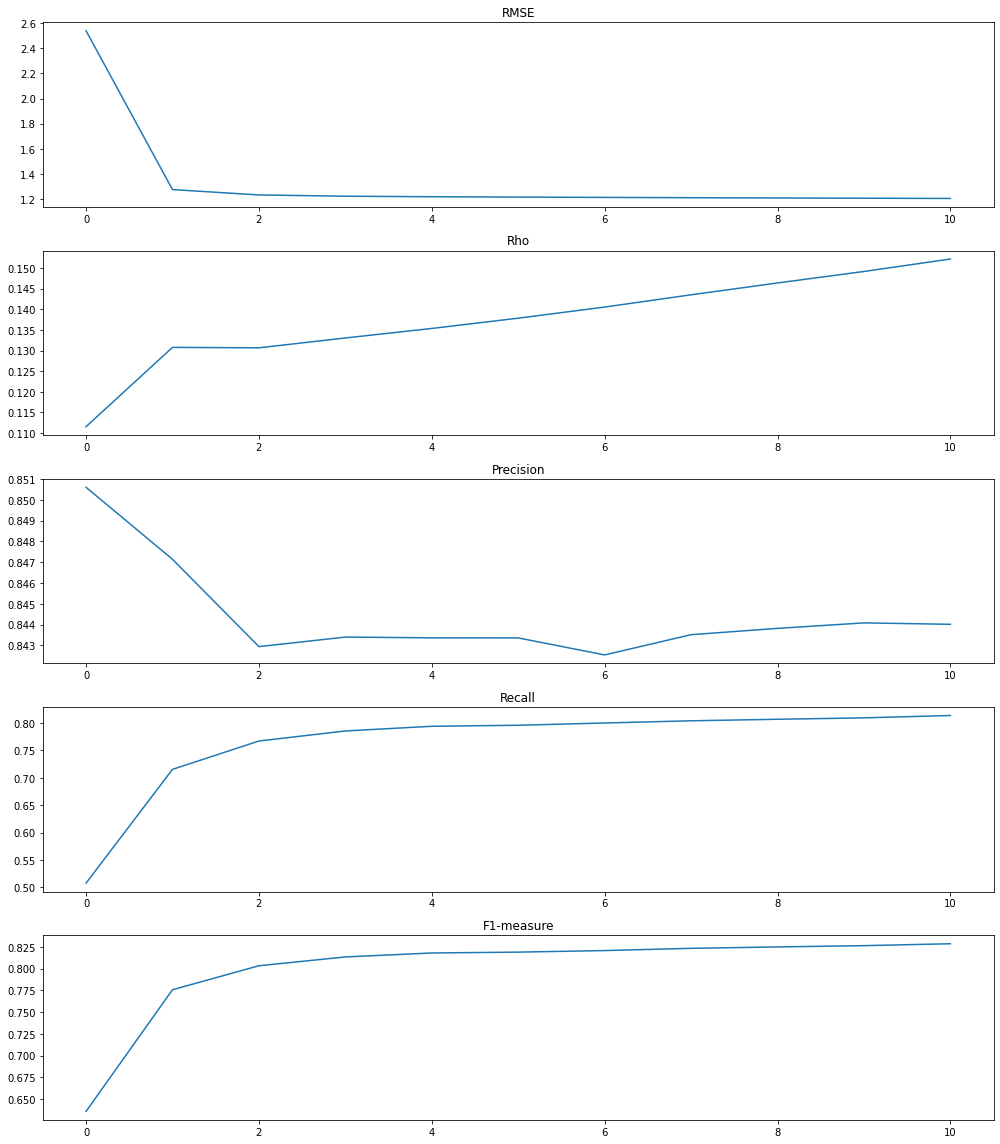

In [75]:
# Show the variations 
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig , axis = plt.subplots(5 , 1 , figsize = (14 , 16))

axis[0].plot(RMSE_list)
axis[0].set_title("RMSE")

axis[1].plot(rho_list)
axis[1].set_title("Rho")

axis[2].plot(precision_list)
axis[2].set_title("Precision")

axis[3].plot(recall_list)
axis[3].set_title("Recall")

axis[4].plot(f1_score_list)
axis[4].set_title("F1-measure")